In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from env import host, user, password
#import wrangle
from sklearn.impute import SimpleImputer

Exercises II

Let's set up an example scenario as perspective for our regression exercises using the Zillow dataset.
As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the obervations from 2017.

In these exercises, you will complete the first step toward the above goal: acquire and prepare the necessary Zillow data from the zillow database in the Codeup database server.

# Acquire data

1. Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips from the zillow database for all 'Single Family Residential' properties.

In [2]:
# connection url

# This function uses my info from the env file to create a connection url to access the Codeup db.
# It takes in a string name of a database as an argument.

def get_connection(db, user=user, host=host, password=password):
    
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
# acquiring data for the first time

def get_zillow_db():
    '''
    This function reads in the zillow data from the Codeup db
    and returns a pandas DataFrame with all columns and it was joined with other tables.
    '''
    sql_query = '''
        select bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet,
         taxvaluedollarcnt, yearbuilt, taxamount, fips from properties_2017
        join propertylandusetype
        on propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
        and propertylandusetype.propertylandusetypeid = 261
        '''
    return pd.read_sql(sql_query, get_connection('zillow'))

In [4]:
# running function and assigning to dataframe

df = get_zillow_db()

# Preparing Data

2. Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaninful; remember to document your process and decisions using markdown and code commenting where helpful.

In [5]:
# Look at dataframe

df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [6]:
# Looking at data shape

df.shape

(2152863, 7)

In [7]:
# Looking at data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 115.0 MB


In [8]:
# Summary statistics for the DataFrame

df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2152852.0,3.287196,0.954754,0.00,3.00,3.00,4.00,25.00
bathroomcnt,2152852.0,2.230688,0.999280,0.00,2.00,2.00,3.00,32.00
calculatedfinishedsquarefeet,2144379.0,1862.855178,1222.125124,1.00,1257.00,1623.00,2208.00,952576.00
taxvaluedollarcnt,2152370.0,461896.237963,699676.049600,1.00,188170.25,327671.00,534527.00,98428909.00
yearbuilt,2143526.0,1960.949681,22.162196,1801.00,1949.00,1958.00,1976.00,2016.00
taxamount,2148421.0,5634.865978,8178.910249,1.85,2534.98,4108.95,6414.32,1337755.86
fips,2152863.0,6048.377335,20.433292,6037.00,6037.00,6037.00,6059.00,6111.00


In [9]:
# Looking for missing values

df.isna().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8484
taxvaluedollarcnt                493
yearbuilt                       9337
taxamount                       4442
fips                               0
dtype: int64

# Filling missing values in the dataframe

In [10]:
# Use mean imputer function

imputer = SimpleImputer(strategy = 'mean')

In [11]:
# Using loop that will impute all the null values in each column

for col in df.columns:
    df[[col]] = imputer.fit_transform(df[[col]])

In [12]:
# Recheck for missing values

df.isna().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
dtype: int64

# Remove Outliers

In [13]:
# function for getting rid of outliers in dataframe, the higher the k, the more outliers you keep.
# usually, you’ll see k start at 1.5, or 3 or less, depending on how many outliers you want to keep.

def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [14]:
df = remove_outliers(df, 2.5, df.columns)

# Distribution of data columns

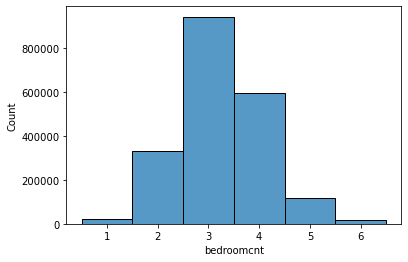

In [15]:
# Bedroom Count

bedroom_count_distro = sns.histplot(data = df, x = "bedroomcnt", discrete = True)

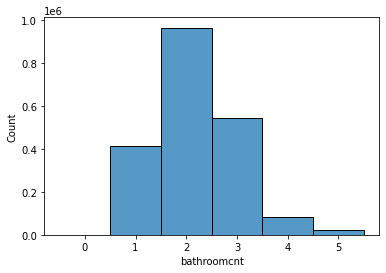

In [16]:
# Bathroom Count

bathroom_count_distro = sns.histplot(data = df, x = "bathroomcnt", discrete = True)

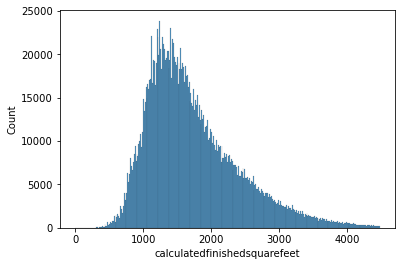

In [17]:
# Finished square feet

finished_square_feet_distro = sns.histplot(data = df, x = "calculatedfinishedsquarefeet")

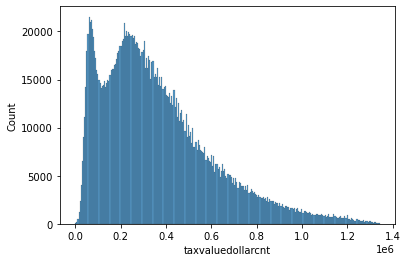

In [18]:
# Tax Value

tax_value_distro = sns.histplot(data = df, x = "taxvaluedollarcnt")

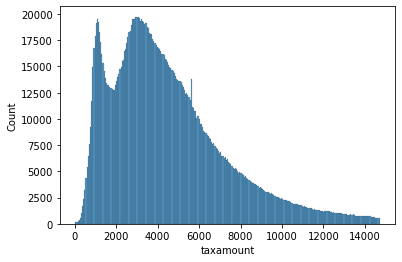

In [21]:
# Tax Amount  

tax_amount_distro = sns.histplot(data = df, x = "taxamount")

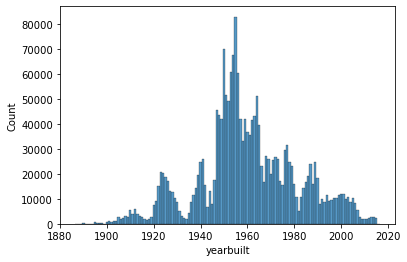

In [19]:
# Year built

year_built_distro = sns.histplot(data = df, x = "yearbuilt", discrete = True)

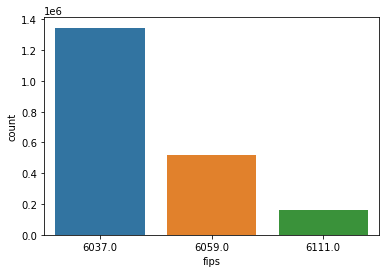

In [20]:
# FIPS - countplot is visually better than histplot for this graph

fips_distro = sns.countplot(data = df, x = "fips")

Federal Information Processing System (FIPS) Codes for States and Counties. FIPS codes are numbers which uniquely identify geographic areas

3. Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe witn no missing values in your wrangle.py file. Name your final function wrangle_zillow.

In [ ]:
df = wrangle_zillow()